In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import os

In [39]:
import pickle

In [2]:
DATA_FILE = os.path.join('../data', 'train.csv')

In [3]:
data = pd.read_csv(DATA_FILE, parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [4]:
data.iloc[0:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
data.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration'],
      dtype='object')

In [6]:
data['pickup_hr'] = data['pickup_datetime'].dt.hour
data['pickup_min'] = data['pickup_datetime'].dt.minute
data['pickup_sec'] = data['pickup_datetime'].dt.second
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data['pickup_date'] = data['pickup_datetime'].dt.day
data['pickup_mon'] = data['pickup_datetime'].dt.month
data['pickup_yr'] = data['pickup_datetime'].dt.year

In [7]:
data = data.assign(pickup_longitude=lambda df: np.round(df.pickup_longitude, 4))
data = data.assign(pickup_latitude=lambda df: np.round(df.pickup_latitude, 4))
data = data.assign(dropoff_longitude=lambda df: np.round(df.dropoff_longitude, 4))
data = data.assign(dropoff_latitude=lambda df: np.round(df.dropoff_latitude, 4))

In [8]:
data = data.assign(st_dist=lambda df: np.sqrt((df.pickup_longitude-df.dropoff_longitude)**2 + 
                                       (df.pickup_latitude-df.dropoff_latitude)**2))

In [9]:
data.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'pickup_yr', u'st_dist'],
      dtype='object')

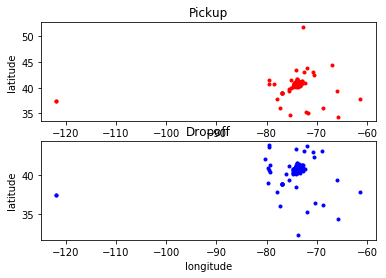

In [10]:
plt.subplot(2, 1, 1)
plt.plot(data['pickup_longitude'], data['pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['dropoff_longitude'], data['dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [11]:
data['s_pickup_latitude'] = (data['pickup_latitude'] - data['pickup_latitude'].min())/(data['pickup_latitude'].max() - data['pickup_latitude'].min())
data['s_pickup_longitude'] = (data['pickup_longitude'] - data['pickup_longitude'].min())/(data['pickup_longitude'].max() - data['pickup_longitude'].min())

data['s_dropoff_latitude'] = (data['dropoff_latitude'] - data['dropoff_latitude'].min())/(data['dropoff_latitude'].max() - data['dropoff_latitude'].min())
data['s_dropoff_longitude'] = (data['dropoff_longitude'] - data['dropoff_longitude'].min())/(data['dropoff_longitude'].max() - data['dropoff_longitude'].min())

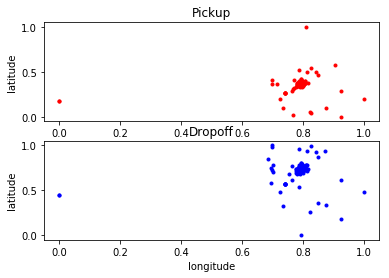

In [12]:
plt.subplot(2, 1, 1)
plt.plot(data['s_pickup_longitude'], data['s_pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['s_dropoff_longitude'], data['s_dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [13]:
data['flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)

In [14]:
data['month_end'] = (data['pickup_datetime'].dt.is_month_end).astype(int)
data['month_start'] = (data['pickup_datetime'].dt.is_month_start).astype(int)

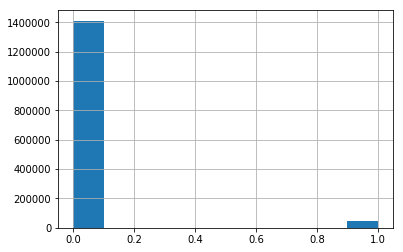

In [15]:
data['month_start'].hist()

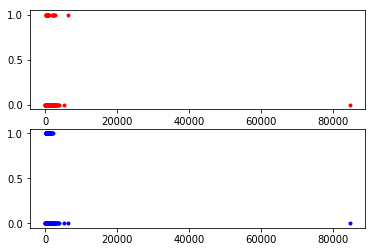

In [16]:
plt.subplot(2, 1, 1)
plt.plot(data['trip_duration'][:1000], data['month_end'][:1000], 'r.')

plt.subplot(2, 1, 2)
plt.plot(data['trip_duration'][:1000], data['month_start'][:1000], 'b.')

plt.show()

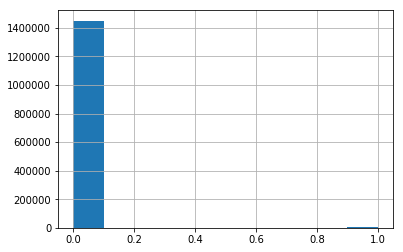

In [17]:
data['flag'].hist()

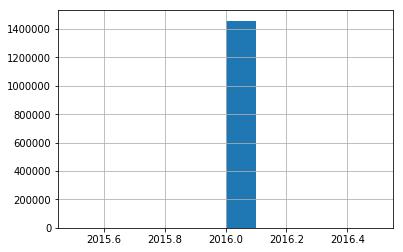

In [18]:
data['pickup_yr'].hist()

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime

In [20]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2015, 12, 31), end=datetime(2017, 1, 1))

data['holiday'] = (data['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays)).astype(int)

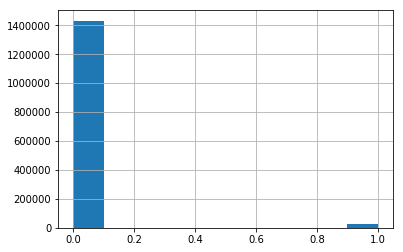

In [21]:
data['holiday'].hist()

In [22]:
from haversine import haversine

def haversine_dist(pos):
    p1 = (pos[0], pos[1])
    p2 = (pos[2], pos[1])
    p3 = (pos[2], pos[3])
    dist = haversine(p1, p2) + haversine(p2, p3)
    return dist

def bearing(pos):
    lat1 = np.radians(pos[0])
    lat2 = np.radians(pos[2])
    
    diffLong = np.radians(pos[1] - pos[3])
    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [23]:
positions = data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
data['h_dist'] = map(lambda p: haversine_dist(p), positions.as_matrix())
data['bearing'] = map(lambda p: bearing(p), positions.as_matrix())

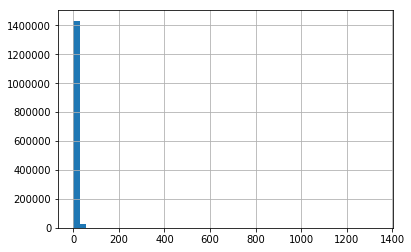

In [24]:
data['h_dist'].hist(bins=50)

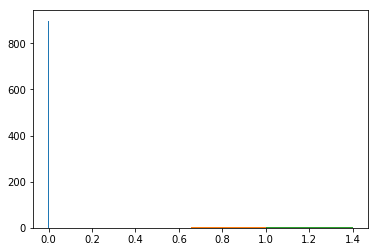

In [25]:
from matplotlib import pyplot as plt

plt.hist(data['h_dist'], bins=50, normed=True, range=(-0.001, 0.04))
plt.hist(data['h_dist'], bins=50, normed=True, range=(0.04, 1))
plt.hist(data['h_dist'], bins=50, normed=True, range=(1, 1.4))
plt.show()

In [27]:
df1 = data[['pickup_longitude', 'pickup_latitude']].as_matrix()
df2 = data[['dropoff_longitude', 'dropoff_latitude']].as_matrix()
features = np.round(np.vstack([df1, df2]), 5)

In [28]:
from sklearn.cluster import MiniBatchKMeans

In [29]:
cluster = MiniBatchKMeans(n_clusters=16, max_iter=500, batch_size=100000, verbose=0, compute_labels=True, 
                          random_state=None, tol=0.0, max_no_improvement=10, n_init=3, reassignment_ratio=0.005)

In [30]:
cluster.fit(features)

MiniBatchKMeans(batch_size=100000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=500, max_no_improvement=10, n_clusters=16,
        n_init=3, random_state=None, reassignment_ratio=0.005, tol=0.0,
        verbose=0)

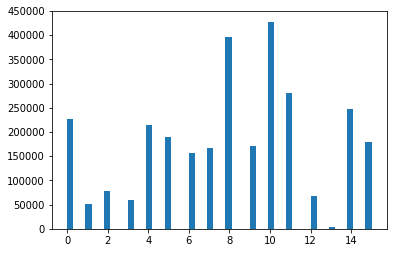

In [31]:
_ = plt.hist(cluster.labels_, bins=50)
plt.show()

In [32]:
data['pickup_cluster_label'] = cluster.predict(data[['pickup_longitude', 'pickup_latitude']])
data['dropoff_cluster_label'] = cluster.predict(data[['dropoff_longitude', 'dropoff_latitude']])

In [33]:
idx = data['pickup_cluster_label'].as_matrix()
data['pickup_cluster_longitude'] = cluster.cluster_centers_[idx][:, 0]
data['pickup_cluster_latitude'] = cluster.cluster_centers_[idx][:, 1]

idx = data['dropoff_cluster_label'].as_matrix()
data['dropoff_cluster_longitude'] = cluster.cluster_centers_[idx][:, 0]
data['dropoff_cluster_latitude'] = cluster.cluster_centers_[idx][:, 1]

In [34]:
positions = data[['pickup_cluster_latitude', 'pickup_cluster_longitude', 
                  'dropoff_cluster_latitude', 'dropoff_cluster_longitude']]
data['cluster_dist'] = map(lambda p: haversine_dist(p), positions.as_matrix())

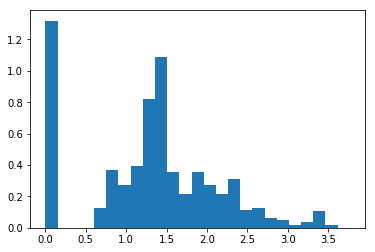

In [35]:
_ = plt.hist(np.log(data['cluster_dist'] + 1.0), bins=25, normed=1)
plt.show()

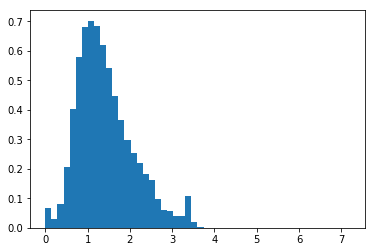

In [36]:
_ = plt.hist(np.log(data['h_dist'] + 1.0), bins=50, normed=1)
plt.show()

In [40]:
pickle.dump(cluster, open( "cluster.p", "wb" ))